# Autonomous driving - Car detection



## Problem Statement

You are working on a self-driving car. As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

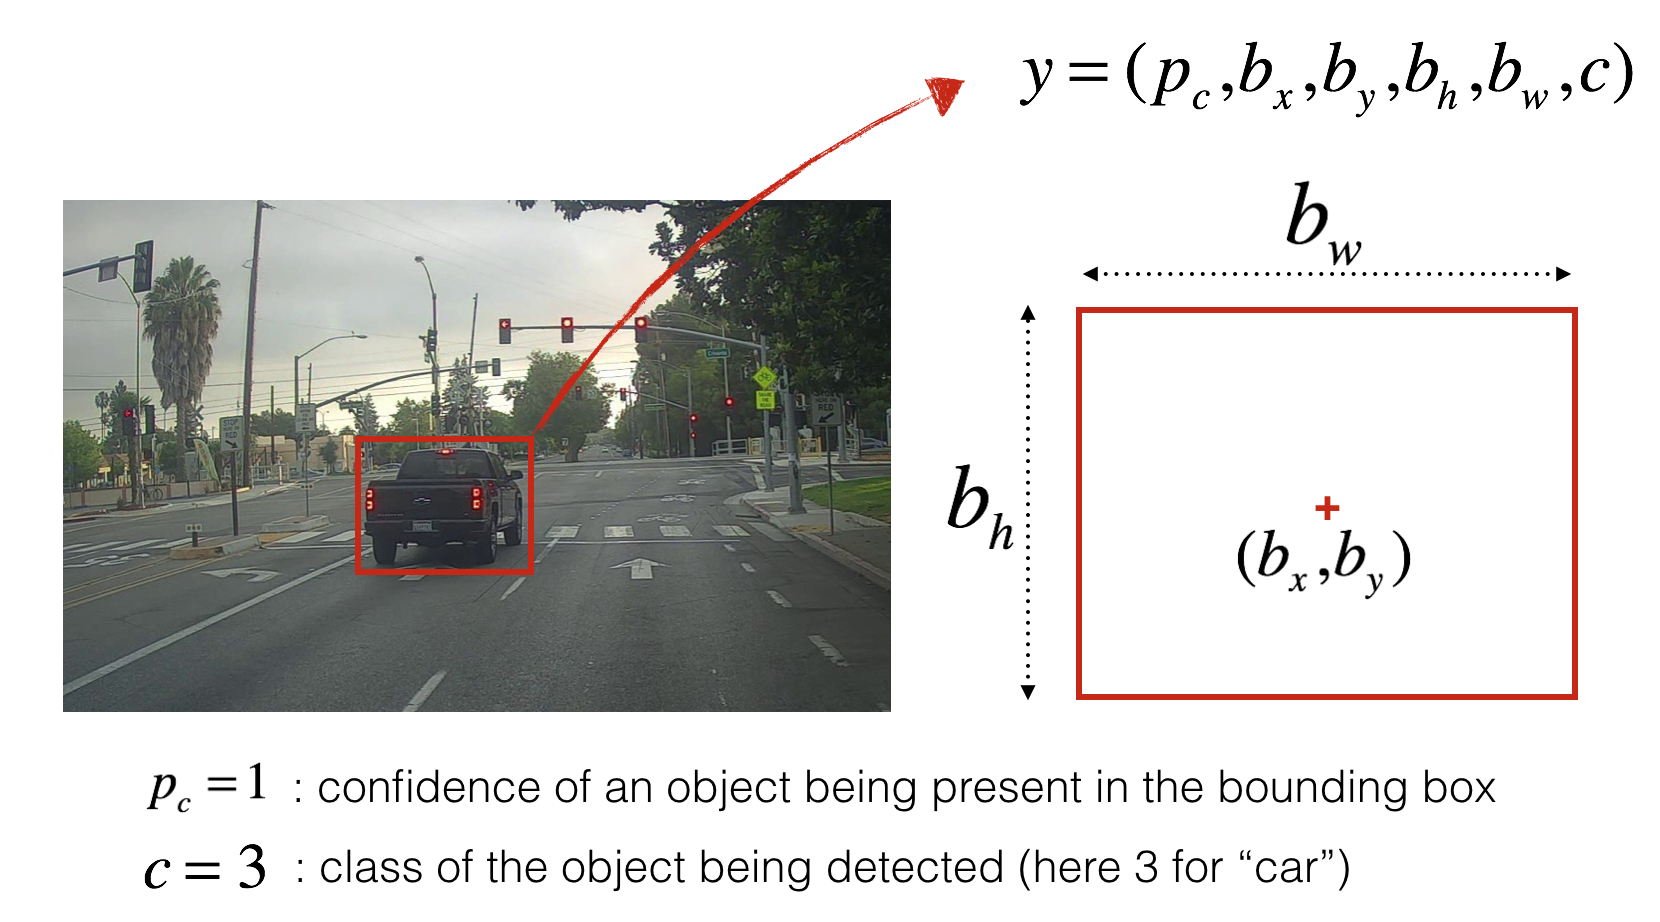
<caption><center> **Definition of a box**<br> </center></caption>

**Tasks**:
- Use object detection on a car detection dataset
- Deal with bounding boxes

## Import libraries


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## Model YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### Filter Boxes

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". 
    filtering_mask = box_class_scores>=threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.7506
boxes[2] = [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### Intersection over Union (IoU)

In [8]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max((xi2-xi1),0)
    inter_height = max((yi2-yi1),0)
    inter_area = inter_height * inter_width

    # Calculate the Union area 
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

In [9]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


### Non Max Suppression

In [10]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() 
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. 
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold=0.5, name=None)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [11]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.9384
boxes[2] = [-5.299932    3.13798141  4.45036697  0.95942086]
classes[2] = -2.24527
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Model Evaluation

In [12]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence,boxes,box_class_probs,score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)
    
    
    return scores, boxes, classes

In [13]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.791
boxes[2] = [ 1292.32971191  -278.52166748  3876.98925781  -835.56494141]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


## Summary for YOLO:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

## Test YOLO pre-trained model on images

In [14]:
sess = K.get_session()

In [15]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [16]:
yolo_model = load_model("model_data/yolo.h5")

/opt/conda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [18]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [19]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [20]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


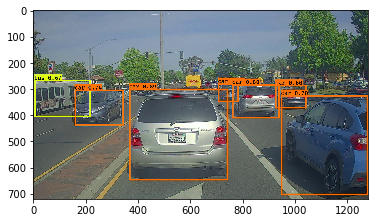

In [21]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are grateful to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 